In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import scipy
from py_vollib.black_scholes import black_scholes

In [153]:
K = 10
sigma = 0.2
r = 0.04
dt = 0.002
T = 0.5
S_low = 4
S_high = 6

In [237]:
def pde_eval(i, j, dt, dx, sigma, r, V_matrix):
    n_X = len(V_matrix[0])-1
    if j == 1:  
        dv = dt*(0.5 * sigma**2 * (V_matrix[i, j+1] - 2*V_matrix[i, j])/(dx*dx) + (r - 0.5 * sigma**2) * (V_matrix[i, j+1] - V_matrix[i, j]) / dx - r*V_matrix[i, j])
    elif j == n_X-1:  
        dv = dt*(0.5 * sigma**2 * (V_matrix[i, j] - V_matrix[i, j-1])/(dx*dx) + (r - 0.5 * sigma**2) * (V_matrix[i, j] - V_matrix[i, j-1]) / dx - r*V_matrix[i, j])
    else:  
        dv = dt*(0.5 * sigma**2 * (V_matrix[i, j+1] - 2*V_matrix[i, j] + V_matrix[i, j-1])/(dx*dx) + (r - 0.5 * sigma**2) * (V_matrix[i, j+1] - V_matrix[i, j-1]) / (2 * dx) - r*V_matrix[i, j])
    return dv

def explicit_findiff(n_T, n_X, dt, dx, sigma, r, V_matrix, option_type="E", option_kind='P', payoff=None):
    Pu = dt * (0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx))
    Pm = 1 - dt * (sigma**2 / dx**2 + r)
    Pd = dt * (0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx))
    for i in range(n_T, 0, -1):
        for j in range(1, n_X):
            V_matrix[i-1, j] = Pu * V_matrix[i, j+1] + Pm * V_matrix[i, j] + Pd * V_matrix[i, j-1]
            if (option_type=="A"):
                V_matrix[i-1, j] = max(V_matrix[i-1, j], payoff[j])
    return V_matrix

def implicit_findiff(n_T, n_X, dt, dx, sigma, r, V_matrix, option_type="E", option_kind='P', payoff=None):
    j = np.arange(1, n_X)
    Pu = -0.5 * dt * ((sigma**2 * j**2) + r - 0.5*sigma**2)
    Pm = 1 + dt * ((sigma**2 * j**2) + r)
    Pd = -0.5 * dt * ((sigma**2 * j**2) - r - 0.5*sigma**2)

    ab = np.zeros((3, n_X-1))
    ab[0, 1:] = Pu[1:]
    ab[1, :] = Pm
    ab[2, :-1] = Pd[:-1]

    # Modify the first row of the matrix for boundary condition
    ab[0, 0] = 0
    ab[1, 0] = 1
    ab[2, 0] = -1

    # Modify the last row of the matrix for boundary condition
    ab[0, -1] = 0
    ab[1, -1] = 1
    ab[2, -1] = -1

    for i in reversed(range(n_T)):
        B = Pu * V_matrix[i+1, :-2] + Pm * V_matrix[i+1, 1:-1] + Pd * V_matrix[i+1, 2:]
        B[0] = V_matrix[i+1, 1] - (np.exp(dx) - 1)
        B[-1] = V_matrix[i+1, -3] + (np.exp(dx*n_X) - np.exp(dx*(n_X-1)))

        V_matrix[i, 1:-1] = scipy.linalg.solve_banded((1, 1), ab, B)
        if option_type == "A":
            V_matrix[i, 1:-1] = np.maximum(V_matrix[i, 1:-1], payoff[1:-1])

    return V_matrix

def crank_nicolson(n_T, n_X, dt, dx, sigma, r, V_matrix, option_type="E", option_kind='P', payoff=None):
    j = np.arange(1, n_X)
    Pu = -0.25 * dt * ((sigma**2 * j**2) + r - 0.5*sigma**2)
    Pm = 1 + 0.5 * dt * ((sigma**2 * j**2) + r)
    Pd = -0.25 * dt * ((sigma**2 * j**2) - r - 0.5*sigma**2)

    ab = np.zeros((3, n_X-1))
    ab[0, 1:] = Pu[1:]
    ab[1, :] = Pm
    ab[2, :-1] = Pd[:-1]

    # Modify the first row of the matrix for boundary condition
    ab[0, 0] = 0
    ab[1, 0] = 1
    ab[2, 0] = -1

    # Modify the last row of the matrix for boundary condition
    ab[0, -1] = 0
    ab[1, -1] = 1
    ab[2, -1] = -1

    for i in reversed(range(n_T)):
        B = -Pu * V_matrix[i+1, :-2] - (Pm - 2) * V_matrix[i+1, 1:-1] - Pd * V_matrix[i+1, 2:]
        B[0] = V_matrix[i+1, 1] - (np.exp(dx) - 1)
        B[-1] = V_matrix[i+1, -3] + (np.exp(dx*n_X) - np.exp(dx*(n_X-1)))

        V_matrix[i, 1:-1] = scipy.linalg.solve_banded((1, 1), ab, B)
        V_matrix[i, 1:-1] = np.maximum(V_matrix[i, 1:-1], 0)
        if option_type == "A":
            V_matrix[i, 1:-1] = np.maximum(V_matrix[i, 1:-1], payoff[1:-1])

    return V_matrix


def eval_option_matrix(K, r, T, sigma, dt, dx, diff_method, option_type='E', option_kind='P'):
    X_min = np.log(4)
    X_max = np.log(16)
    X_values = np.arange(X_min, X_max+dx, dx)
    n_X = len(X_values) - 1
    n_T = int(T/dt)

    V_matrix = np.zeros((n_T+1, n_X+1))

    if option_kind == 'P':
        payoff = np.maximum(0, K - np.exp(X_values)) 
        V_matrix[n_T] = payoff 
        V_matrix[:, 0] = np.maximum(0, K * np.exp(-r*np.arange(n_T+1)[::-1]*dt) - np.exp(X_min))
        V_matrix[:, n_X] = np.maximum(0, K * np.exp(-r*np.arange(n_T+1)[::-1]*dt) - np.exp(X_max))
    elif option_kind == 'C':
        payoff = np.maximum(0, np.exp(X_values)-K)
        V_matrix[n_T] = payoff 
        V_matrix[:, 0] = np.maximum(0, np.exp(X_min) - K * np.exp(-r*np.arange(n_T+1)[::-1]*dt))
        V_matrix[:, n_X] = np.maximum(0, np.exp(X_max) - K * np.exp(-r*np.arange(n_T+1)[::-1]*dt))
    
    V_matrix = diff_method(n_T, n_X, dt, dx, sigma, r, V_matrix, option_type, option_kind, payoff)
    return X_values, V_matrix

def option_price(S, X_values, V_matrix):
    if S < np.exp(X_values.min()) or S > np.exp(X_values.max()):
        raise ValueError("The stock price is out of the calculated range.")
    interp = scipy.interpolate.interp1d(np.exp(X_values), V_matrix[0, :])
    return interp(S)


def option_price(S, X_values, V_matrix):
    interp = scipy.interpolate.interp1d(np.exp(X_values), V_matrix[0, :])
    return interp(S)

#### Question 1

### dx = $ \sigma \sqrt{dt}$

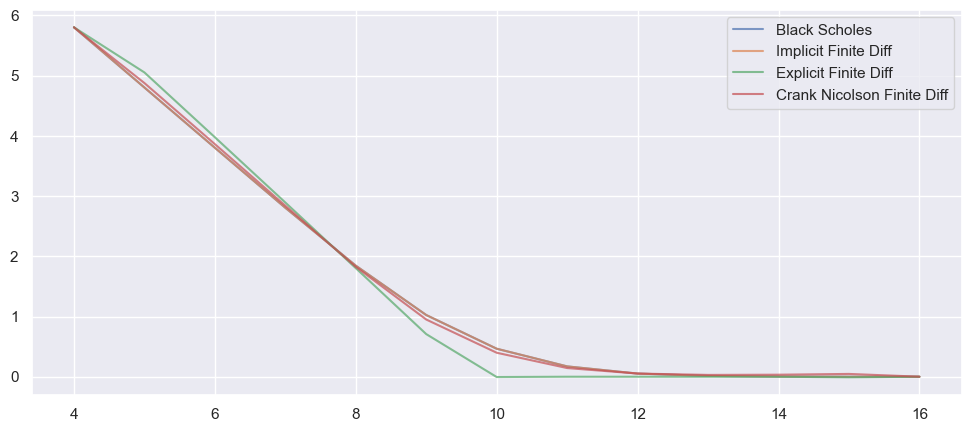

In [246]:
dx = sigma * np.sqrt(dt)
S = [s for s in range(4, 16+1)]
X_values_exp, V_matrix_exp = eval_option_matrix(K, r, T, sigma, dt, dx, explicit_findiff)
X_values_imp, V_matrix_imp = eval_option_matrix(K, r, T, sigma, dt, dx, implicit_findiff)
X_values_cn, V_matrix_cn = eval_option_matrix(K, r, T, sigma, dt, dx, crank_nicolson)

bs_prices = []
exp_prices = []
imp_prices = []
cn_prices = []

for s in S:
    bs_prices.append(black_scholes('p', s, K, T, r, sigma))    
    
    exp_prices.append(option_price(s, X_values_exp, V_matrix_exp))
    imp_prices.append(option_price(s, X_values_imp, V_matrix_imp))
    cn_prices.append(option_price(s, X_values_cn, V_matrix_cn))
    
plt.figure(figsize=(12,5))
plt.plot(S, bs_prices, label="Black Scholes", alpha=0.7)
plt.plot(S, exp_prices, label="Implicit Finite Diff", alpha=0.7)
plt.plot(S, imp_prices, label="Explicit Finite Diff", alpha=0.7)
plt.plot(S, cn_prices, label="Crank Nicolson Finite Diff", alpha=0.7)
plt.legend()
plt.show()

In [243]:
df = pd.DataFrame(columns=["Stock Price", "Explicit SE", "Implicit SE", "Crank Nicolson SE"])
df["Stock Price"] = S
df["Explicit SE"] = np.array(imp_prices) - np.array(bs_prices)
df["Implicit SE"] = np.array(exp_prices) - np.array(bs_prices)
df["Crank Nicolson SE"] = np.array(cn_prices) - np.array(bs_prices)
df

,Stock Price,Explicit SE,Implicit SE,Crank Nicolson SE
0,4,-1.552714e-11,-1.552714e-11,-1.552714e-11
1,5,2.504577e-01,-8.589684e-06,7.427039e-02
2,6,1.743148e-01,-1.284208e-05,6.001391e-02
3,7,8.756125e-02,-4.548588e-05,3.418329e-02
4,8,-4.116533e-02,-3.988604e-06,-1.970072e-02
5,9,-3.166599e-01,3.216310e-04,-7.460452e-02
6,10,-4.697780e-01,5.424767e-04,-6.642160e-02
7,11,-1.715369e-01,2.812367e-04,-2.754622e-02
8,12,-5.245962e-02,9.011975e-05,2.879844e-04
9,13,-1.365245e-02,-1.162559e-05,1.648429e-02


### dx = $ \sigma \sqrt{3*dt}$

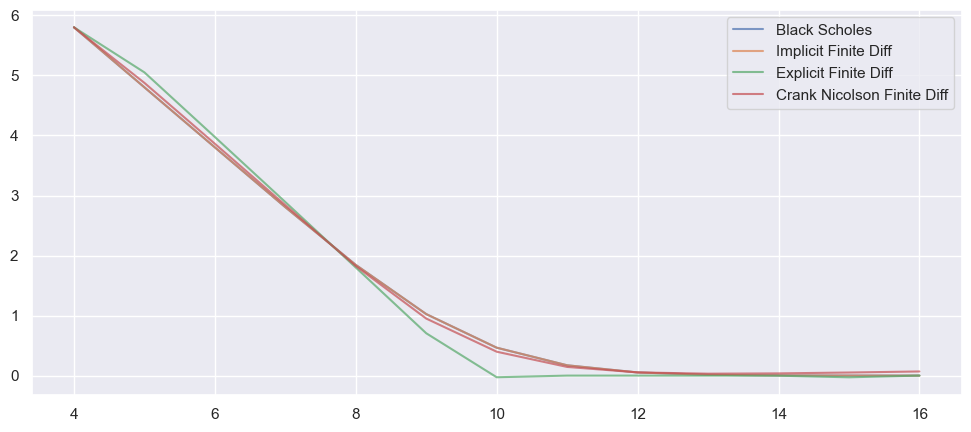

In [249]:
dx = sigma * np.sqrt(3*dt)
S = [s for s in range(4, 16+1)]
X_values_exp, V_matrix_exp = eval_option_matrix(K, r, T, sigma, dt, dx, explicit_findiff)
X_values_imp, V_matrix_imp = eval_option_matrix(K, r, T, sigma, dt, dx, implicit_findiff)
X_values_cn, V_matrix_cn = eval_option_matrix(K, r, T, sigma, dt, dx, crank_nicolson)

bs_prices = []
exp_prices = []
imp_prices = []
cn_prices = []

for s in S:
    bs_prices.append(black_scholes('p', s, K, T, r, sigma))    
    
    exp_prices.append(option_price(s, X_values_exp, V_matrix_exp))
    imp_prices.append(option_price(s, X_values_imp, V_matrix_imp))
    cn_prices.append(option_price(s, X_values_cn, V_matrix_cn))
    
plt.figure(figsize=(12,5))
plt.plot(S, bs_prices, label="Black Scholes", alpha=0.7)
plt.plot(S, exp_prices, label="Implicit Finite Diff", alpha=0.7)
plt.plot(S, imp_prices, label="Explicit Finite Diff", alpha=0.7)
plt.plot(S, cn_prices, label="Crank Nicolson Finite Diff", alpha=0.7)
plt.legend()
plt.show()

In [250]:
df = pd.DataFrame(columns=["Stock Price", "Explicit SE", "Implicit SE", "Crank Nicolson SE"])
df["Stock Price"] = S
df["Explicit SE"] = np.array(imp_prices) - np.array(bs_prices)
df["Implicit SE"] = np.array(exp_prices) - np.array(bs_prices)
df["Crank Nicolson SE"] = np.array(cn_prices) - np.array(bs_prices)
df

,Stock Price,Explicit SE,Implicit SE,Crank Nicolson SE
0,4,-1.552714e-11,-1.552714e-11,-1.552714e-11
1,5,2.490657e-01,-1.049262e-05,7.426347e-02
2,6,1.726354e-01,-1.077209e-05,6.000980e-02
3,7,8.558987e-02,-3.000877e-07,3.419171e-02
4,8,-4.343548e-02,1.430034e-04,-1.951191e-02
5,9,-3.190425e-01,4.895935e-04,-7.429721e-02
6,10,-4.922173e-01,2.850085e-04,-6.668551e-02
7,11,-1.715375e-01,4.313212e-04,-2.717819e-02
8,12,-5.245965e-02,6.342727e-05,1.038911e-03
9,13,-1.366284e-02,2.064541e-05,1.831055e-02


### dx = $ \sigma \sqrt{4*dt}$

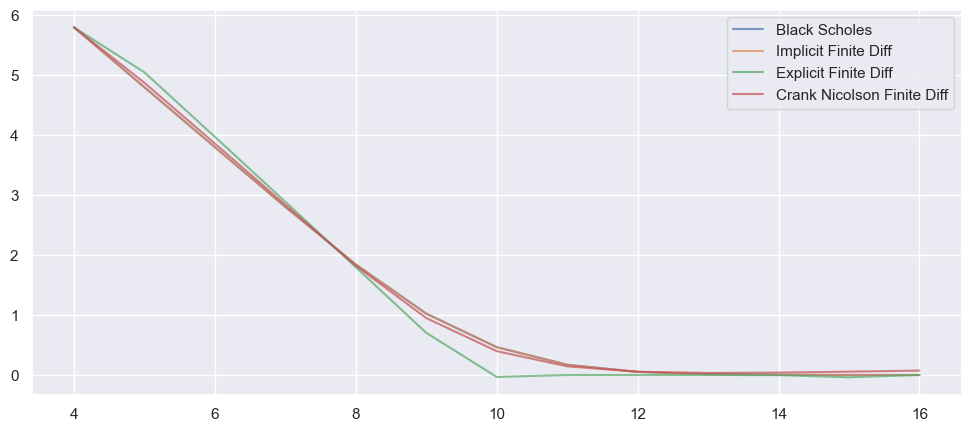

In [251]:
dx = sigma * np.sqrt(4*dt)
S = [s for s in range(4, 16+1)]
X_values_exp, V_matrix_exp = eval_option_matrix(K, r, T, sigma, dt, dx, explicit_findiff)
X_values_imp, V_matrix_imp = eval_option_matrix(K, r, T, sigma, dt, dx, implicit_findiff)
X_values_cn, V_matrix_cn = eval_option_matrix(K, r, T, sigma, dt, dx, crank_nicolson)

bs_prices = []
exp_prices = []
imp_prices = []
cn_prices = []

for s in S:
    bs_prices.append(black_scholes('p', s, K, T, r, sigma))    
    
    exp_prices.append(option_price(s, X_values_exp, V_matrix_exp))
    imp_prices.append(option_price(s, X_values_imp, V_matrix_imp))
    cn_prices.append(option_price(s, X_values_cn, V_matrix_cn))
    
plt.figure(figsize=(12,5))
plt.plot(S, bs_prices, label="Black Scholes", alpha=0.7)
plt.plot(S, exp_prices, label="Implicit Finite Diff", alpha=0.7)
plt.plot(S, imp_prices, label="Explicit Finite Diff", alpha=0.7)
plt.plot(S, cn_prices, label="Crank Nicolson Finite Diff", alpha=0.7)
plt.legend()
plt.show()

In [252]:
df = pd.DataFrame(columns=["Stock Price", "Explicit SE", "Implicit SE", "Crank Nicolson SE"])
df["Stock Price"] = S
df["Explicit SE"] = np.array(imp_prices) - np.array(bs_prices)
df["Implicit SE"] = np.array(exp_prices) - np.array(bs_prices)
df["Crank Nicolson SE"] = np.array(cn_prices) - np.array(bs_prices)
df

,Stock Price,Explicit SE,Implicit SE,Crank Nicolson SE
0,4,-1.552714e-11,-1.552714e-11,-1.552714e-11
1,5,2.485544e-01,-1.143971e-05,7.426060e-02
2,6,1.720147e-01,-8.604279e-06,6.000344e-02
3,7,8.486012e-02,6.118478e-05,3.419481e-02
4,8,-4.427027e-02,3.110360e-04,-1.936315e-02
5,9,-3.198333e-01,7.893672e-04,-7.394252e-02
6,10,-4.963325e-01,7.099219e-04,-6.619059e-02
7,11,-1.715359e-01,8.243073e-04,-2.658435e-02
8,12,-5.245971e-02,4.600231e-04,2.148526e-03
9,13,-1.367601e-02,1.133306e-04,2.021038e-02


#### Question 2

#### Put options

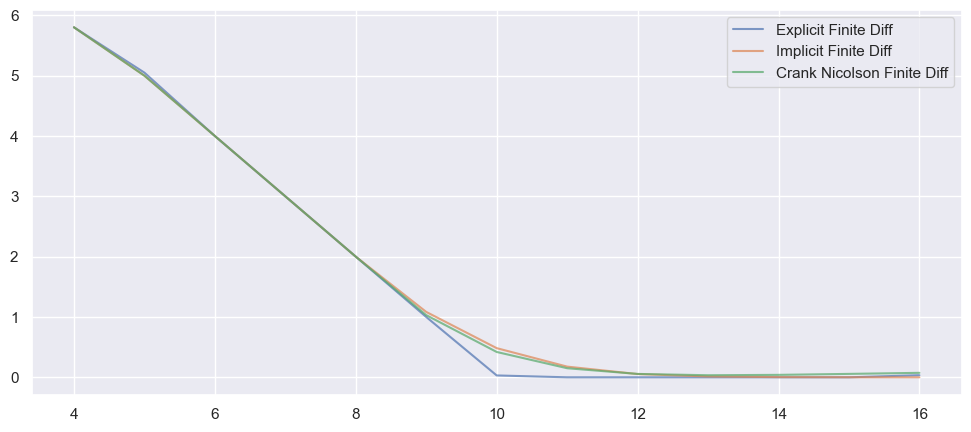

In [253]:
S = [s for s in range(4, 16+1)]
X_values_exp, V_matrix_exp = eval_option_matrix(K, r, T, sigma, dt, dx, explicit_findiff, 'A')
X_values_imp, V_matrix_imp = eval_option_matrix(K, r, T, sigma, dt, dx, implicit_findiff, 'A')
X_values_cn, V_matrix_cn = eval_option_matrix(K, r, T, sigma, dt, dx, crank_nicolson, 'A')

exp_prices = []
imp_prices = []
cn_prices = []

for s in S:
    exp_prices.append(option_price(s, X_values_exp, V_matrix_exp))
    imp_prices.append(option_price(s, X_values_imp, V_matrix_imp))
    cn_prices.append(option_price(s, X_values_cn, V_matrix_cn))
    
plt.figure(figsize=(12,5))

plt.plot(S, imp_prices, label="Explicit Finite Diff", alpha=0.7)
plt.plot(S, exp_prices, label="Implicit Finite Diff", alpha=0.7)
plt.plot(S, cn_prices, label="Crank Nicolson Finite Diff", alpha=0.7)
plt.legend()
plt.show()

#### Call options

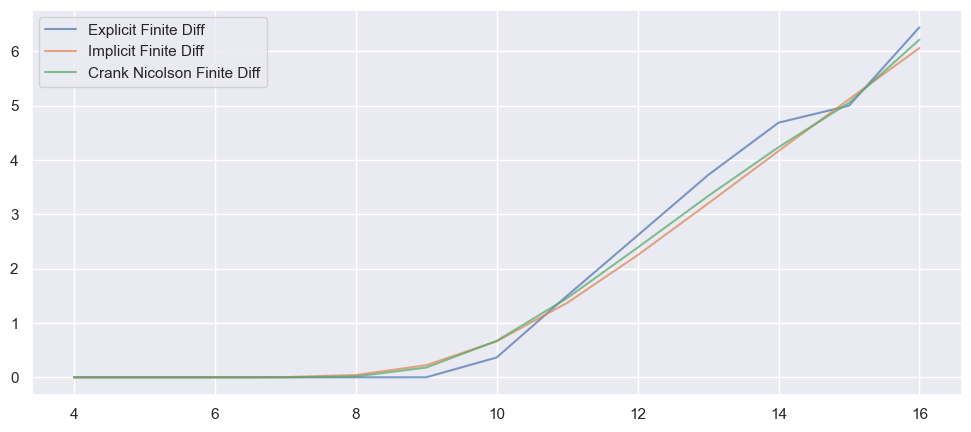

In [254]:
S = [s for s in range(4, 16+1)]
X_values_exp, V_matrix_exp = eval_option_matrix(K, r, T, sigma, dt, dx, explicit_findiff, 'A', 'C')
X_values_imp, V_matrix_imp = eval_option_matrix(K, r, T, sigma, dt, dx, implicit_findiff, 'A', 'C')
X_values_cn, V_matrix_cn = eval_option_matrix(K, r, T, sigma, dt, dx, crank_nicolson, 'A', 'C')

exp_prices = []
imp_prices = []
cn_prices = []

for s in S:
    exp_prices.append(option_price(s, X_values_exp, V_matrix_exp))
    imp_prices.append(option_price(s, X_values_imp, V_matrix_imp))
    cn_prices.append(option_price(s, X_values_cn, V_matrix_cn))
    
plt.figure(figsize=(12,5))

plt.plot(S, imp_prices, label="Explicit Finite Diff", alpha=0.7)
plt.plot(S, exp_prices, label="Implicit Finite Diff", alpha=0.7)
plt.plot(S, cn_prices, label="Crank Nicolson Finite Diff", alpha=0.7)
plt.legend()
plt.show()